## Setup Env

In [ ]:
!pip install yolov5 pycocotools tqdm roboflow pyyaml

In [1]:
import yolov5
display = yolov5.utils.notebook_init()  # checks

initialization = False  # set to True if you need to download the dataset and preprocessing
to_train = False  # set to True if you want to train a model

YOLOv5 🚀 2024-3-13 Python-3.11.7 torch-2.2.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12042MiB)


Setup complete ✅ (12 CPUs, 31.2 GB RAM, 50.1/139.7 GB disk)


## Preprocessing

### Download Data

In [2]:
if initialization:
    from roboflow import Roboflow
    
    
    rf = Roboflow(api_key="your key")
    project = rf.workspace("roboflow-gw7yv").project("self-driving-car")
    dataset = project.version(3).download("yolov5")

### Read Data

In [3]:
import os
import yaml
try:
  from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
  from yaml import Loader, Dumper

with open('Self-Driving-Car-3/data.yaml') as f:
  data_meta = yaml.load(f.read(), Loader=Loader)
data_meta

{'names': ['biker',
  'car',
  'pedestrian',
  'trafficLight',
  'trafficLight-Green',
  'trafficLight-GreenLeft',
  'trafficLight-Red',
  'trafficLight-RedLeft',
  'trafficLight-Yellow',
  'trafficLight-YellowLeft',
  'truck'],
 'nc': 11,
 'roboflow': {'license': 'MIT',
  'project': 'self-driving-car',
  'url': 'https://universe.roboflow.com/roboflow-gw7yv/self-driving-car/dataset/3',
  'version': 3,
  'workspace': 'roboflow-gw7yv'},
 'test': '../test/images',
 'train': 'Self-Driving-Car-3/train/images',
 'val': 'Self-Driving-Car-3/valid/images'}

In [4]:
path_images = os.path.join('Self-Driving-Car-3', 'export', 'images')
path_labels = os.path.join('Self-Driving-Car-3', 'export', 'labels')
print(len(os.listdir(path_images)), len(os.listdir(path_labels)))

29800 29800


In [5]:
if initialization:
    os.listdir(path_images)[-1]

In [6]:
if initialization:
    path_0 = os.listdir(path_labels)[30]
    path_0

In [7]:
if initialization:
    with open(os.path.join(path_labels, path_0)) as f:
      label_0 = f.read()
    print(label_0)

In [8]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt


if initialization:
    LABELS = os.listdir(path_labels)
    
    
    def show_image(ind):
      pth = LABELS[ind]
      with open(os.path.join(path_labels, pth)) as f:
        label = f.read()
      img = Image.open(os.path.join(
          path_images, os.path.splitext(pth)[0] + '.jpg'))
      print(f'{img.size=}')
      width, height = img.size
    
      plt.imshow(img)
      for line in label.split('\n'):
        cx, cy, w, h = map(float, line.split(' ')[1:])
        cx *= width
        cy *= height
        w *= width
        h *= height
        x = cx - w / 2
        y = cy - h / 2
        coor = [(x, y), (x + w, y), (x + w, y + h), (x, y + h), (x, y)]
        coor = np.array(coor)
        plt.plot(*coor.T)
      print(label)
    
    
    show_image(30)

### Train-Text-Valid Split

In [9]:
import shutil
import random
from tqdm import tqdm

if initialization:
    def split_train_text_valid(labels, ratios=[0.7, 0.2, 0.1], path=''):
        labels = list(set(labels))
        random.shuffle(labels)
        cut_1, cut_2 = ratios[:2]
        cut_2 += cut_1
        cut_1 = int(len(labels) * cut_1)
        cut_2 = int(len(labels) * cut_2)
        train = labels[:cut_1]
        test = labels[cut_1: cut_2]
        valid = labels[cut_2:]

        for name, dataset in zip(['train', 'test', 'valid'], [train, test, valid]):
            pth_lab = os.path.join(path, name, 'labels')
            pth_img = os.path.join(path, name, 'images')
            try:
                shutil.rmtree(pth_lab)
            except:
                pass
            try:
                shutil.rmtree(pth_img)
            except:
                pass
            os.makedirs(pth_lab, exist_ok=True)
            os.makedirs(pth_img, exist_ok=True)

            for lab in tqdm(dataset):
                img = os.path.splitext(lab)[0] + '.jpg'
                shutil.copyfile(os.path.join(path_images, img),
                                os.path.join(pth_img, img))
                shutil.copyfile(os.path.join(path_labels, lab),
                                os.path.join(pth_lab, lab))
    
    
    split_train_text_valid(LABELS)

In [10]:
print(f'{len(os.listdir("train/images"))=}')
print(f'{len(os.listdir("test/images"))=}')
print(f'{len(os.listdir("valid/images"))=}')

len(os.listdir("train/images"))=20860
len(os.listdir("test/images"))=5959
len(os.listdir("valid/images"))=2981


In [11]:
data_meta['path'] = os.path.abspath('')
data_meta['train'] = 'train/images'
data_meta['val'] = 'valid/images'
data_meta['test'] = 'test/images'
data_meta

{'names': ['biker',
  'car',
  'pedestrian',
  'trafficLight',
  'trafficLight-Green',
  'trafficLight-GreenLeft',
  'trafficLight-Red',
  'trafficLight-RedLeft',
  'trafficLight-Yellow',
  'trafficLight-YellowLeft',
  'truck'],
 'nc': 11,
 'roboflow': {'license': 'MIT',
  'project': 'self-driving-car',
  'url': 'https://universe.roboflow.com/roboflow-gw7yv/self-driving-car/dataset/3',
  'version': 3,
  'workspace': 'roboflow-gw7yv'},
 'test': 'test/images',
 'train': 'train/images',
 'val': 'valid/images',
 'path': '/home/anthony/Documents/Homework Documents/Inno Lab 8'}

In [12]:
from yolov5.utils.general import check_dataset


data = check_dataset(data_meta)

## Model Training

### Setup model

In [13]:
# hyper-parameters
train_path, test_path, val_path = data["train"], data['test'], data["val"]
nc, names = len(data["names"]), data["names"]

hyp = {'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0,
       'warmup_momentum': 0.8, 'warmup_bias_lr': 0.1, 'box': 0.05, 'cls': 0.5, 'cls_pw': 1.0, 'obj': 1.0, 'obj_pw': 1.0,
       'iou_t': 0.2, 'anchor_t': 4.0, 'fl_gamma': 0.0, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0,
       'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'mosaic': 1.0,
       'mixup': 0.0, 'copy_paste': 0.0}

cfg = {'nc': nc, 'depth_multiple': 0.33, 'width_multiple': 0.25,
       'anchors': [[10, 13, 16, 30, 33, 23], [30, 61, 62, 45, 59, 119], [116, 90, 156, 198, 373, 326]],
       'backbone': [[-1, 1, 'Conv', [64, 6, 2, 2]], [-1, 1, 'Conv', [128, 3, 2]], [-1, 3, 'C3', [128]],
                    [-1, 1, 'Conv', [256, 3, 2]], [-1, 6, 'C3', [256]], [-1, 1, 'Conv', [512, 3, 2]],
                    [-1, 9, 'C3', [512]], [-1, 1, 'Conv', [1024, 3, 2]], [-1, 3, 'C3', [1024]],
                    [-1, 1, 'SPPF', [1024, 5]]],
       'head': [[-1, 1, 'Conv', [512, 1, 1]], [-1, 1, 'nn.Upsample', ['None', 2, 'nearest']],
                [[-1, 6], 1, 'Concat', [1]], [-1, 3, 'C3', [512, False]], [-1, 1, 'Conv', [256, 1, 1]],
                [-1, 1, 'nn.Upsample', ['None', 2, 'nearest']], [[-1, 4], 1, 'Concat', [1]],
                [-1, 3, 'C3', [256, False]], [-1, 1, 'Conv', [256, 3, 2]], [[-1, 14], 1, 'Concat', [1]],
                [-1, 3, 'C3', [512, False]], [-1, 1, 'Conv', [512, 3, 2]], [[-1, 10], 1, 'Concat', [1]],
                [-1, 3, 'C3', [1024, False]], [[17, 20, 23], 1, 'Detect', ['nc', 'anchors']]]}

device = "cuda"
num_epochs = 1
batch_size = 64
img_size = 512

In [14]:
# set up model
import torch
from yolov5.utils.torch_utils import model_info
from yolov5.models.yolo import Model

model = torch.hub.load('ultralytics/yolov5', 'yolov5s', autoshape=False, pretrained=True).model
model = model.half().float()
model.hyp = hyp # attach hyperparameters to model
model.nc = nc  # attach number of classes to model
model.names = names  # attach class names to model
model.verbose = True
model_info(model)

Using cache found in /home/anthony/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-3-13 Python-3.11.7 torch-2.2.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12042MiB)

YOLOv5s summary: 270 layers, 7235389 parameters, 0 gradients, 16.6 GFLOPs


In [15]:
# check layers
for k, v in model.named_parameters():
    print(k)

model.0.conv.weight
model.0.bn.weight
model.0.bn.bias
model.1.conv.weight
model.1.bn.weight
model.1.bn.bias
model.2.cv1.conv.weight
model.2.cv1.bn.weight
model.2.cv1.bn.bias
model.2.cv2.conv.weight
model.2.cv2.bn.weight
model.2.cv2.bn.bias
model.2.cv3.conv.weight
model.2.cv3.bn.weight
model.2.cv3.bn.bias
model.2.m.0.cv1.conv.weight
model.2.m.0.cv1.bn.weight
model.2.m.0.cv1.bn.bias
model.2.m.0.cv2.conv.weight
model.2.m.0.cv2.bn.weight
model.2.m.0.cv2.bn.bias
model.3.conv.weight
model.3.bn.weight
model.3.bn.bias
model.4.cv1.conv.weight
model.4.cv1.bn.weight
model.4.cv1.bn.bias
model.4.cv2.conv.weight
model.4.cv2.bn.weight
model.4.cv2.bn.bias
model.4.cv3.conv.weight
model.4.cv3.bn.weight
model.4.cv3.bn.bias
model.4.m.0.cv1.conv.weight
model.4.m.0.cv1.bn.weight
model.4.m.0.cv1.bn.bias
model.4.m.0.cv2.conv.weight
model.4.m.0.cv2.bn.weight
model.4.m.0.cv2.bn.bias
model.4.m.1.cv1.conv.weight
model.4.m.1.cv1.bn.weight
model.4.m.1.cv1.bn.bias
model.4.m.1.cv2.conv.weight
model.4.m.1.cv2.bn.weigh

In [16]:
# frozee backbone
freeze_layers = [f'model.{x}.' for x in range(10)]
for k, v in model.named_parameters():
    v.requires_grad = True  # train all layers
    if any(x in k for x in freeze_layers):
        print(f'freezing {k}')
        v.requires_grad = False


freezing model.0.conv.weight
freezing model.0.bn.weight
freezing model.0.bn.bias
freezing model.1.conv.weight
freezing model.1.bn.weight
freezing model.1.bn.bias
freezing model.2.cv1.conv.weight
freezing model.2.cv1.bn.weight
freezing model.2.cv1.bn.bias
freezing model.2.cv2.conv.weight
freezing model.2.cv2.bn.weight
freezing model.2.cv2.bn.bias
freezing model.2.cv3.conv.weight
freezing model.2.cv3.bn.weight
freezing model.2.cv3.bn.bias
freezing model.2.m.0.cv1.conv.weight
freezing model.2.m.0.cv1.bn.weight
freezing model.2.m.0.cv1.bn.bias
freezing model.2.m.0.cv2.conv.weight
freezing model.2.m.0.cv2.bn.weight
freezing model.2.m.0.cv2.bn.bias
freezing model.3.conv.weight
freezing model.3.bn.weight
freezing model.3.bn.bias
freezing model.4.cv1.conv.weight
freezing model.4.cv1.bn.weight
freezing model.4.cv1.bn.bias
freezing model.4.cv2.conv.weight
freezing model.4.cv2.bn.weight
freezing model.4.cv2.bn.bias
freezing model.4.cv3.conv.weight
freezing model.4.cv3.bn.weight
freezing model.4.c

### Data Loader

In [17]:
# data loader
import numpy as np
from yolov5.utils.dataloaders import create_dataloader

train_loader, dataset = create_dataloader(
    train_path,
    img_size,
    batch_size,
    max(int(model.stride.max()), 32),
    hyp=hyp,
    augment=True,
    shuffle=True,
)

# test loader
test_loader, dataset = create_dataloader(
    test_path,
    img_size,
    batch_size,
    max(int(model.stride.max()), 32),
    hyp=hyp,
    augment=False,
    shuffle=False,
)

Scanning /home/anthony/Documents/Homework Documents/Inno Lab 8/train/labels.cach
WARNING ⚠️ /home/anthony/Documents/Homework Documents/Inno Lab 8/train/images/1478021875081281646_jpg.rf.bEZPhuyXU5hIovwQSTIp.jpg: 1 duplicate labels removed
WARNING ⚠️ /home/anthony/Documents/Homework Documents/Inno Lab 8/train/images/1478898145212453716_jpg.rf.6a92d7d7dd523160c990c4e4375bcea9.jpg: 1 duplicate labels removed
WARNING ⚠️ /home/anthony/Documents/Homework Documents/Inno Lab 8/train/images/1478898145212453716_jpg.rf.nCaFkPk4AFMjTQAM4RTJ.jpg: 1 duplicate labels removed
Scanning /home/anthony/Documents/Homework Documents/Inno Lab 8/test/labels.cache
WARNING ⚠️ /home/anthony/Documents/Homework Documents/Inno Lab 8/test/images/1478021875081281646_jpg.rf.e9552980cf8c6fef4aa02cb84c6364f5.jpg: 1 duplicate labels removed
WARNING ⚠️ /home/anthony/Documents/Homework Documents/Inno Lab 8/test/images/1478897760163798179_jpg.rf.5Pzrj3Eg3vZuyl7ztKAt.jpg: 1 duplicate labels removed
WARNING ⚠️ /home/anthony/D

In [18]:
# optimizer and loss
from yolov5.utils.torch_utils import smart_optimizer
from yolov5.utils.loss import ComputeLoss

optimizer = smart_optimizer(model)
compute_loss = ComputeLoss(model)  # Define loss function


optimizer: Adam(lr=0.001) with parameter groups 57 weight(decay=0.0), 60 weight(decay=1e-05), 60 bias


In [19]:
from math import inf
import numpy as np
from tqdm import tqdm
import torch


def train_model(model, loader, pbar=None):
    # training
    model.to(device)
    model.train()

    training_loss = []
    for (imgs, targets, paths, _) in loader:
        # Forward pass
        imgs = imgs.to(device).float() / 255
        pred = model(imgs)
        loss, loss_items = compute_loss(pred, targets.to(device))

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        training_loss.append(loss.item())

        if pbar:
          pbar.set_postfix(loss=np.mean(training_loss))
    return np.mean(training_loss)


def test_model(model, loader, pbar=None):
    # testing
    with torch.no_grad():
        model.to(device)
        model.train()
        test_loss = []
        for (imgs, targets, paths, _) in loader:
            imgs = imgs.to(device).float() / 255
            pred = model(imgs)
            loss, loss_items = compute_loss(pred, targets.to(device))
            test_loss.append(loss.item())

        if pbar:
            pbar.set_postfix(test_loss=np.mean(test_loss))
        return np.mean(test_loss)


def train(model, train_loader, test_loader, num_epochs, best_loss=inf):
    for epoch in range(num_epochs):
        pbar = tqdm(train_loader)
        pbar.set_description(f"Training [{epoch + 1}/{num_epochs}]")
        training_loss = train_model(model, pbar, pbar)
    
        pbar = tqdm(test_loader)
        pbar.set_description(f"Testing [{epoch + 1}/{num_epochs}][{training_loss=:.2f}]")
        test_loss = test_model(model, pbar, pbar)
        pbar.disable = False
        pbar.set_description(f"Testing [{epoch + 1}/{num_epochs}][{training_loss=:.2f}][{test_loss=:.2f}]")
        pbar.update()
        pbar.close()

        # save the best model
        if test_loss < best_loss:
            print(f"Model is saved when {test_loss=}, {epoch=}")
            best_loss = test_loss
            torch.save(model.state_dict(), save_path)

        # overfitting
        if test_loss > training_loss:
            break

    print('Training done!!!')


### Train Model

In [20]:
import torch

save_path = "yolov5s_car_cam.pth"

In [21]:
# Load the trained model weights
try:
    model.load_state_dict(torch.load(save_path))
except Exception as err:
    print(err)

In [22]:
if to_train:
    pbar = tqdm(test_loader)
    pbar.set_description(f"Testing")
    best_loss = test_model(model, pbar, pbar)


In [23]:
# train
if to_train:
    num_epochs = 240
    train(model, train_loader, test_loader, num_epochs, best_loss)


## Evaluation

In [24]:
import torch
from yolov5.models.common import AutoShape


core_model = torch.hub.load("ultralytics/yolov5", 'yolov5s', pretrained=False)
core_model.load_state_dict(torch.load(save_path))
core_model.eval()
model = AutoShape(core_model)
model.nc = nc
model.names = names

Using cache found in /home/anthony/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-3-13 Python-3.11.7 torch-2.2.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12042MiB)


                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Conv                      [3, 32, 6, 2, 2]              
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  2    115712  models.common.C3                        [128, 128, 2]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  3    625152  models.common.C3                        [

In [25]:
from yolov5.utils.dataloaders import create_dataloader


val_loader, dataset = create_dataloader(
    val_path,
    img_size,
    64,
    max(int(model.model.stride.max()), 32),
    hyp=hyp,
    augment=False,
    shuffle=True,
)
iterable = iter(val_loader)

Scanning /home/anthony/Documents/Homework Documents/Inno Lab 8/valid/labels.cach


In [26]:
pbar = tqdm(val_loader)
pbar.set_description(f"Validating")
test_loss = test_model(model, pbar, pbar)
print(f"Validation Loss: {test_loss}")

Validating: 100%|███████████████████████████████| 47/47 [00:08<00:00,  5.82it/s]

Validation Loss: 4.9637219144942915


In [31]:
n_showing = 2

imgs, targets, pths, _ = [x[:n_showing] for x in next(iterable)]
print(f'{imgs.shape=}\n{targets.shape=}\n{len(pths)=}')

imgs.shape=torch.Size([2, 3, 512, 512])
targets.shape=torch.Size([2, 6])
len(pths)=2


In [32]:
model.eval()
pred = model(pths)
pred.print()

image 1/2: 512x512 6 cars, 1 pedestrian, 2 trafficLight-Reds
image 2/2: 512x512 (no detections)
Speed: 4.3ms pre-process, 40.0ms inference, 1.0ms NMS per image at shape (2, 3, 640, 640)


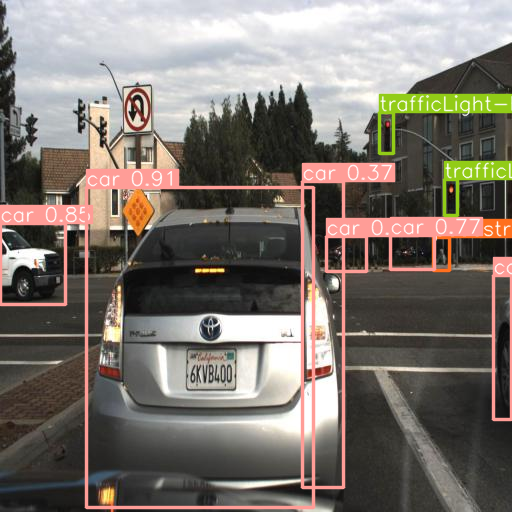

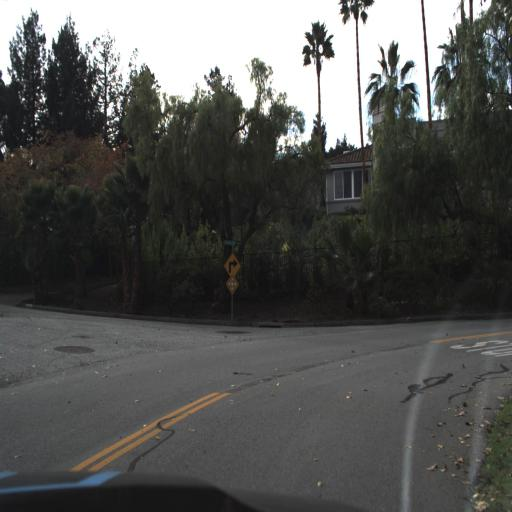

In [33]:
pred.show()

In [34]:
pred.pandas().xyxy

[         xmin        ymin        xmax        ymax  confidence  class  \
 0   86.068542  187.780991  313.081512  507.581360    0.909246      1   
 1    0.000000  223.257111   65.944305  304.928894    0.852656      1   
 2  379.953125  112.612000  393.659027  153.433456    0.816698      6   
 3  444.778320  179.157867  457.719635  215.760544    0.815400      6   
 4  390.728455  235.746384  434.648651  269.366547    0.774095      1   
 5  326.787811  236.086212  366.763397  271.186707    0.656986      1   
 6  433.644287  237.001419  449.340668  270.407959    0.573557      2   
 7  493.861725  275.404877  511.805756  419.142395    0.562450      1   
 8  302.694153  181.850388  343.954193  487.356171    0.371765      1   
 
                name  
 0               car  
 1               car  
 2  trafficLight-Red  
 3  trafficLight-Red  
 4               car  
 5               car  
 6        pedestrian  
 7               car  
 8               car  ,
 Empty DataFrame
 Columns: [xmin, ymi

In [35]:
%matplotlib inline
from PIL import Image
from matplotlib import pyplot as plt


def show_val_image(img):
    pth = img.replace('/images/', '/labels/').replace('.jpg', '.txt')

    img = Image.open(img)
    with open(pth) as f:
      label = f.read()

    print(f'{img.size=}')
    width, height = img.size

    fig, ax = plt.subplots()
    ax.imshow(img)
    for line in label.split('\n'):
      cx, cy, w, h = map(float, line.split(' ')[1:])
      cx *= width
      cy *= height
      w *= width
      h *= height
      x = cx - w / 2
      y = cy - h / 2
      coor = [(x, y), (x + w, y), (x + w, y + h), (x, y + h), (x, y)]
      coor = np.array(coor)
      ax.plot(*coor.T)
    fig.show()



In [ ]:
for img in pths:
    show_val_image(img)